In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
np.random.seed(42)
import random
random.seed(42)

In [2]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

### loading the user_id and ratings

In [3]:
file_path_ratings = os.path.expanduser('ml-latest-small/ratings.csv')
file_path_movies = os.path.expanduser('ml-latest-small/movies.csv')

user_id = []
movie_id = []
ratings = []

# loading the user_id and ratings
with open(file_path_ratings) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user_id.append(int(row['userId']))
        movie_id.append(int(row['movieId']))
        ratings.append(float(row['rating']))

In [4]:
user_number = len(np.unique(user_id))
movie_number = len(np.unique(movie_id))
movie_list = dict()
movie_id_u=[]
movie_idx = 0
for id in movie_id:
    if id not in movie_id_u:
        movie_list[id]=int(movie_idx)
        movie_id_u.append(id)
        movie_idx += 1

In [5]:
print('number of user=',user_number)
print('number of rated movie=',movie_number)
total_available_rating=len(user_id)
total_possible_rating=user_number*movie_number
print('Sparsity=',float(total_available_rating) / total_possible_rating)

number of user= 610
number of rated movie= 9724
Sparsity= 0.016999683055613623


In [6]:
R = np.zeros((user_number, movie_number))  
W = np.zeros((user_number, movie_number))
for i in range(len(user_id)):
    x = user_id[i] - 1
    y =  int(movie_list[movie_id[i]])
    R[x,y] = ratings[i]
    W[x,y]=1

In [7]:
movieFreq = np.sum(R != 0, axis = 0)
movieFreq_dict = {m: movieFreq[movie_list[m]] for m in movie_list.keys()}
movieVar = [np.var([e for e in row if e != 0]) for row in np.transpose(R)]
movieVar_dict = {m: movieVar[movie_list[m]] for m in movie_list.keys()}

In [8]:
# Loading data with built-in functions from surprise
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans,NMF,SVD
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from surprise import accuracy
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader)

## Question 34

In [9]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
# train the model with best k
trainset, testset = train_test_split(data, test_size=0.1)

algo1 = KNNWithMeans(k=22, sim_options={'name': 'pearson', 'user_based': True})
algo2 = NMF(n_factors=16)
algo3 = SVD(n_factors=28)

algo1.fit(trainset)
prediction1 = algo1.test(testset)
algo2.fit(trainset)
prediction2 = algo2.test(testset)
algo3.fit(trainset)
prediction3 = algo3.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


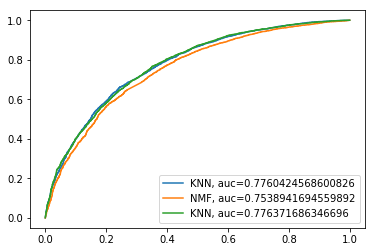

In [10]:
threshold = 3

y = [1 if pred[2] > threshold else 0 for pred in prediction1]
scores1 = [pred[3] for pred in prediction1]
fpr1, tpr1, _ = roc_curve(y, scores1)
auc1 = roc_auc_score(y, scores1)
plt.plot(fpr1,tpr1,label="KNN, auc="+str(auc1))

y = [1 if pred[2] > threshold else 0 for pred in prediction2]
scores2 = [pred[3] for pred in prediction2]
fpr2, tpr2, _ = roc_curve(y, scores2)
auc2 = roc_auc_score(y, scores2)
plt.plot(fpr2,tpr2,label="NMF, auc="+str(auc2))

y = [1 if pred[2] > threshold else 0 for pred in prediction3]
scores3 = [pred[3] for pred in prediction3]
fpr3, tpr3, _ = roc_curve(y, scores3)
auc3 = roc_auc_score(y, scores3)
plt.plot(fpr3,tpr3,label="KNN, auc="+str(auc3))

plt.legend(loc=0)
plt.show()

## Question 36

In [11]:
from collections import defaultdict
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=10, threshold=3):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

Use KFold to choose different number of top ranking recommendations

In [ ]:
kf = KFold(n_splits=10)

In [25]:
prec_hist1 = []
rec_hist1 = []

for t in range(1,26) :
    prec_sum= 0
    rec_sum = 0
    print("t = ", t)
    for trainset, testset in kf.split(data):
        algo1.fit(trainset)
        prediction1 = algo1.test(testset)
        precision1, recall1 = precision_recall_at_k(prediction1, k=t, threshold=3)

        # Precision and recall can then be averaged over all users
        prec_sum += sum(prec for prec in precision1.values()) / len(precision1)
        rec_sum += sum(rec for rec in recall1.values()) / len(recall1)

    prec_sum /= 10
    rec_sum /= 10
    prec_hist1.append(prec_sum)
    rec_hist1.append(rec_sum)

t =  1
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
t =  2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simi

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
t =  12
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
t =  23
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity

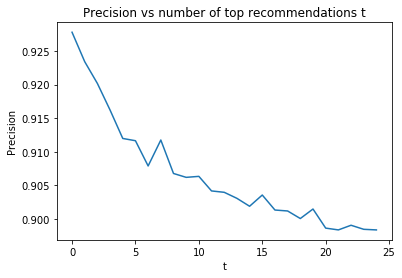

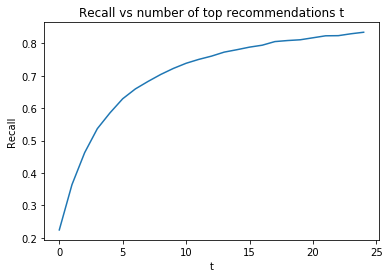

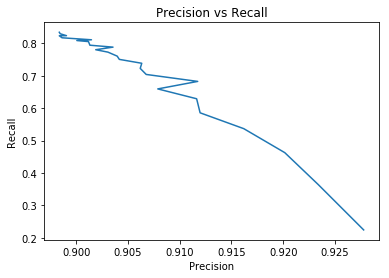

In [26]:
plt.plot(prec_hist1)
plt.title("Precision vs number of top recommendations t")
plt.xlabel('t')
plt.ylabel('Precision')
plt.show()

plt.plot(rec_hist1)
plt.title("Recall vs number of top recommendations t")
plt.xlabel('t')
plt.ylabel('Recall')
plt.show()

plt.plot(prec_hist1, rec_hist1)
plt.title("Precision vs Recall")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

## Question 37

In [27]:
prec_hist2 = []
rec_hist2 = []

for t in range(1,26) :
    prec_sum= 0
    rec_sum = 0
    print("t = ", t)
    for trainset, testset in kf.split(data):
        algo2.fit(trainset)
        prediction2 = algo2.test(testset)
        precision2, recall2 = precision_recall_at_k(prediction2, k=t, threshold=3)

        # Precision and recall can then be averaged over all users
        prec_sum += sum(prec for prec in precision2.values()) / len(precision2)
        rec_sum += sum(rec for rec in recall2.values()) / len(recall2)

    prec_sum /= 10
    rec_sum /= 10
    prec_hist2.append(prec_sum)
    rec_hist2.append(rec_sum)

t =  1
t =  2
t =  3
t =  4
t =  5
t =  6
t =  7
t =  8
t =  9
t =  10
t =  11
t =  12
t =  13
t =  14
t =  15
t =  16
t =  17
t =  18
t =  19
t =  20
t =  21
t =  22
t =  23
t =  24
t =  25


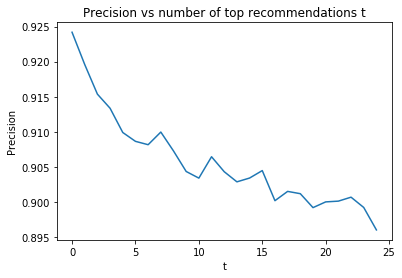

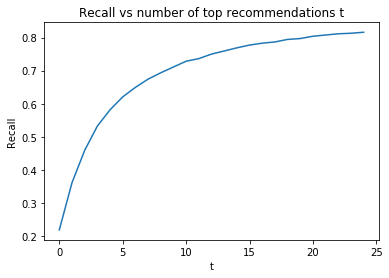

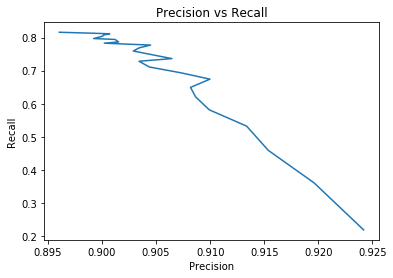

In [28]:
plt.plot(prec_hist2)
plt.title("Precision vs number of top recommendations t")
plt.xlabel('t')
plt.ylabel('Precision')
plt.show()

plt.plot(rec_hist2)
plt.title("Recall vs number of top recommendations t")
plt.xlabel('t')
plt.ylabel('Recall')
plt.show()

plt.plot(prec_hist2, rec_hist2)
plt.title("Precision vs Recall")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

## Question 38

In [29]:
prec_hist3 = []
rec_hist3 = []

for t in range(1,26) :
    prec_sum= 0
    rec_sum = 0
    print("t = ", t)
    for trainset, testset in kf.split(data):
        algo3.fit(trainset)
        prediction3 = algo3.test(testset)
        precision3, recall3 = precision_recall_at_k(prediction3, k=t, threshold=3)

        # Precision and recall can then be averaged over all users
        prec_sum += sum(prec for prec in precision3.values()) / len(precision3)
        rec_sum += sum(rec for rec in recall3.values()) / len(recall3)

    prec_sum /= 10
    rec_sum /= 10
    prec_hist3.append(prec_sum)
    rec_hist3.append(rec_sum)

t =  1
t =  2
t =  3
t =  4
t =  5
t =  6
t =  7
t =  8
t =  9
t =  10
t =  11
t =  12
t =  13
t =  14
t =  15
t =  16
t =  17
t =  18
t =  19
t =  20
t =  21
t =  22
t =  23
t =  24
t =  25


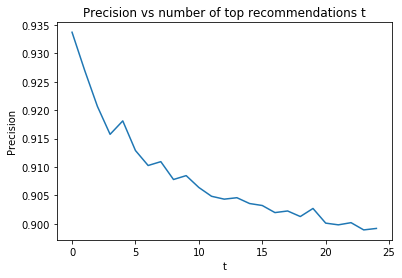

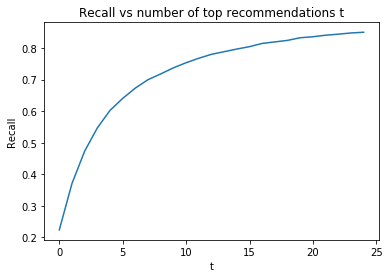

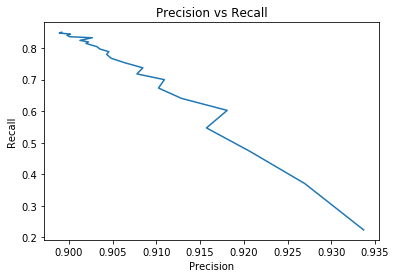

In [30]:
plt.plot(prec_hist3)
plt.title("Precision vs number of top recommendations t")
plt.xlabel('t')
plt.ylabel('Precision')
plt.show()

plt.plot(rec_hist3)
plt.title("Recall vs number of top recommendations t")
plt.xlabel('t')
plt.ylabel('Recall')
plt.show()

plt.plot(prec_hist3, rec_hist3)
plt.title("Precision vs Recall")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

## Question 39

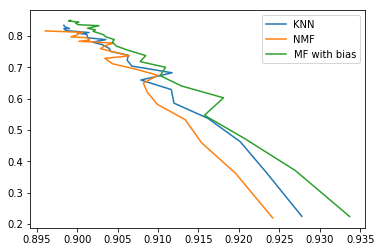

In [31]:
plt.plot(prec_hist1, rec_hist1,label="KNN")
plt.plot(prec_hist2, rec_hist2,label="NMF")
plt.plot(prec_hist3, rec_hist3,label="MF with bias")

plt.legend(loc=0)
plt.show()